In [2]:
from google.colab import files
uploaded = files.upload()


Saving wdbc.names to wdbc.names
Saving wdbc.data to wdbc.data


In [3]:
import pandas as pd
column_names = [
    'ID', 'Diagnosis',
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean', 'smoothness_mean',
    'compactness_mean', 'concavity_mean', 'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
    'compactness_se', 'concavity_se', 'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst',
    'compactness_worst', 'concavity_worst', 'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]


df = pd.read_csv('wdbc.data', header=None, names=column_names)

df.head()

,ID,Diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [4]:
#  Preprocessing & EDA

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler

#  Encode labels (M = malignant, B = benign → 1 / 0)

label_encoder = LabelEncoder()
df['Diagnosis'] = label_encoder.fit_transform(df['Diagnosis'])  # M=1, B=0

df.drop(columns=['ID'], inplace=True)

#  Check for missing values
print("Missing values per column:\n", df.isnull().sum())

Missing values per column:
 Diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave_points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave_points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


In [5]:
#  Feature scaling (Standardization)

features = df.drop('Diagnosis', axis=1)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Replace original features with scaled

df_scaled = pd.DataFrame(features_scaled, columns=features.columns)
df_scaled['Diagnosis'] = df['Diagnosis']

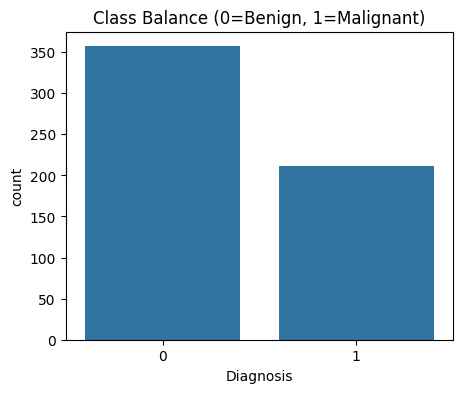

In [6]:
# Class balance visualization

plt.figure(figsize=(5,4))
sns.countplot(x='Diagnosis', data=df_scaled)
plt.title('Class Balance (0=Benign, 1=Malignant)')
plt.show()

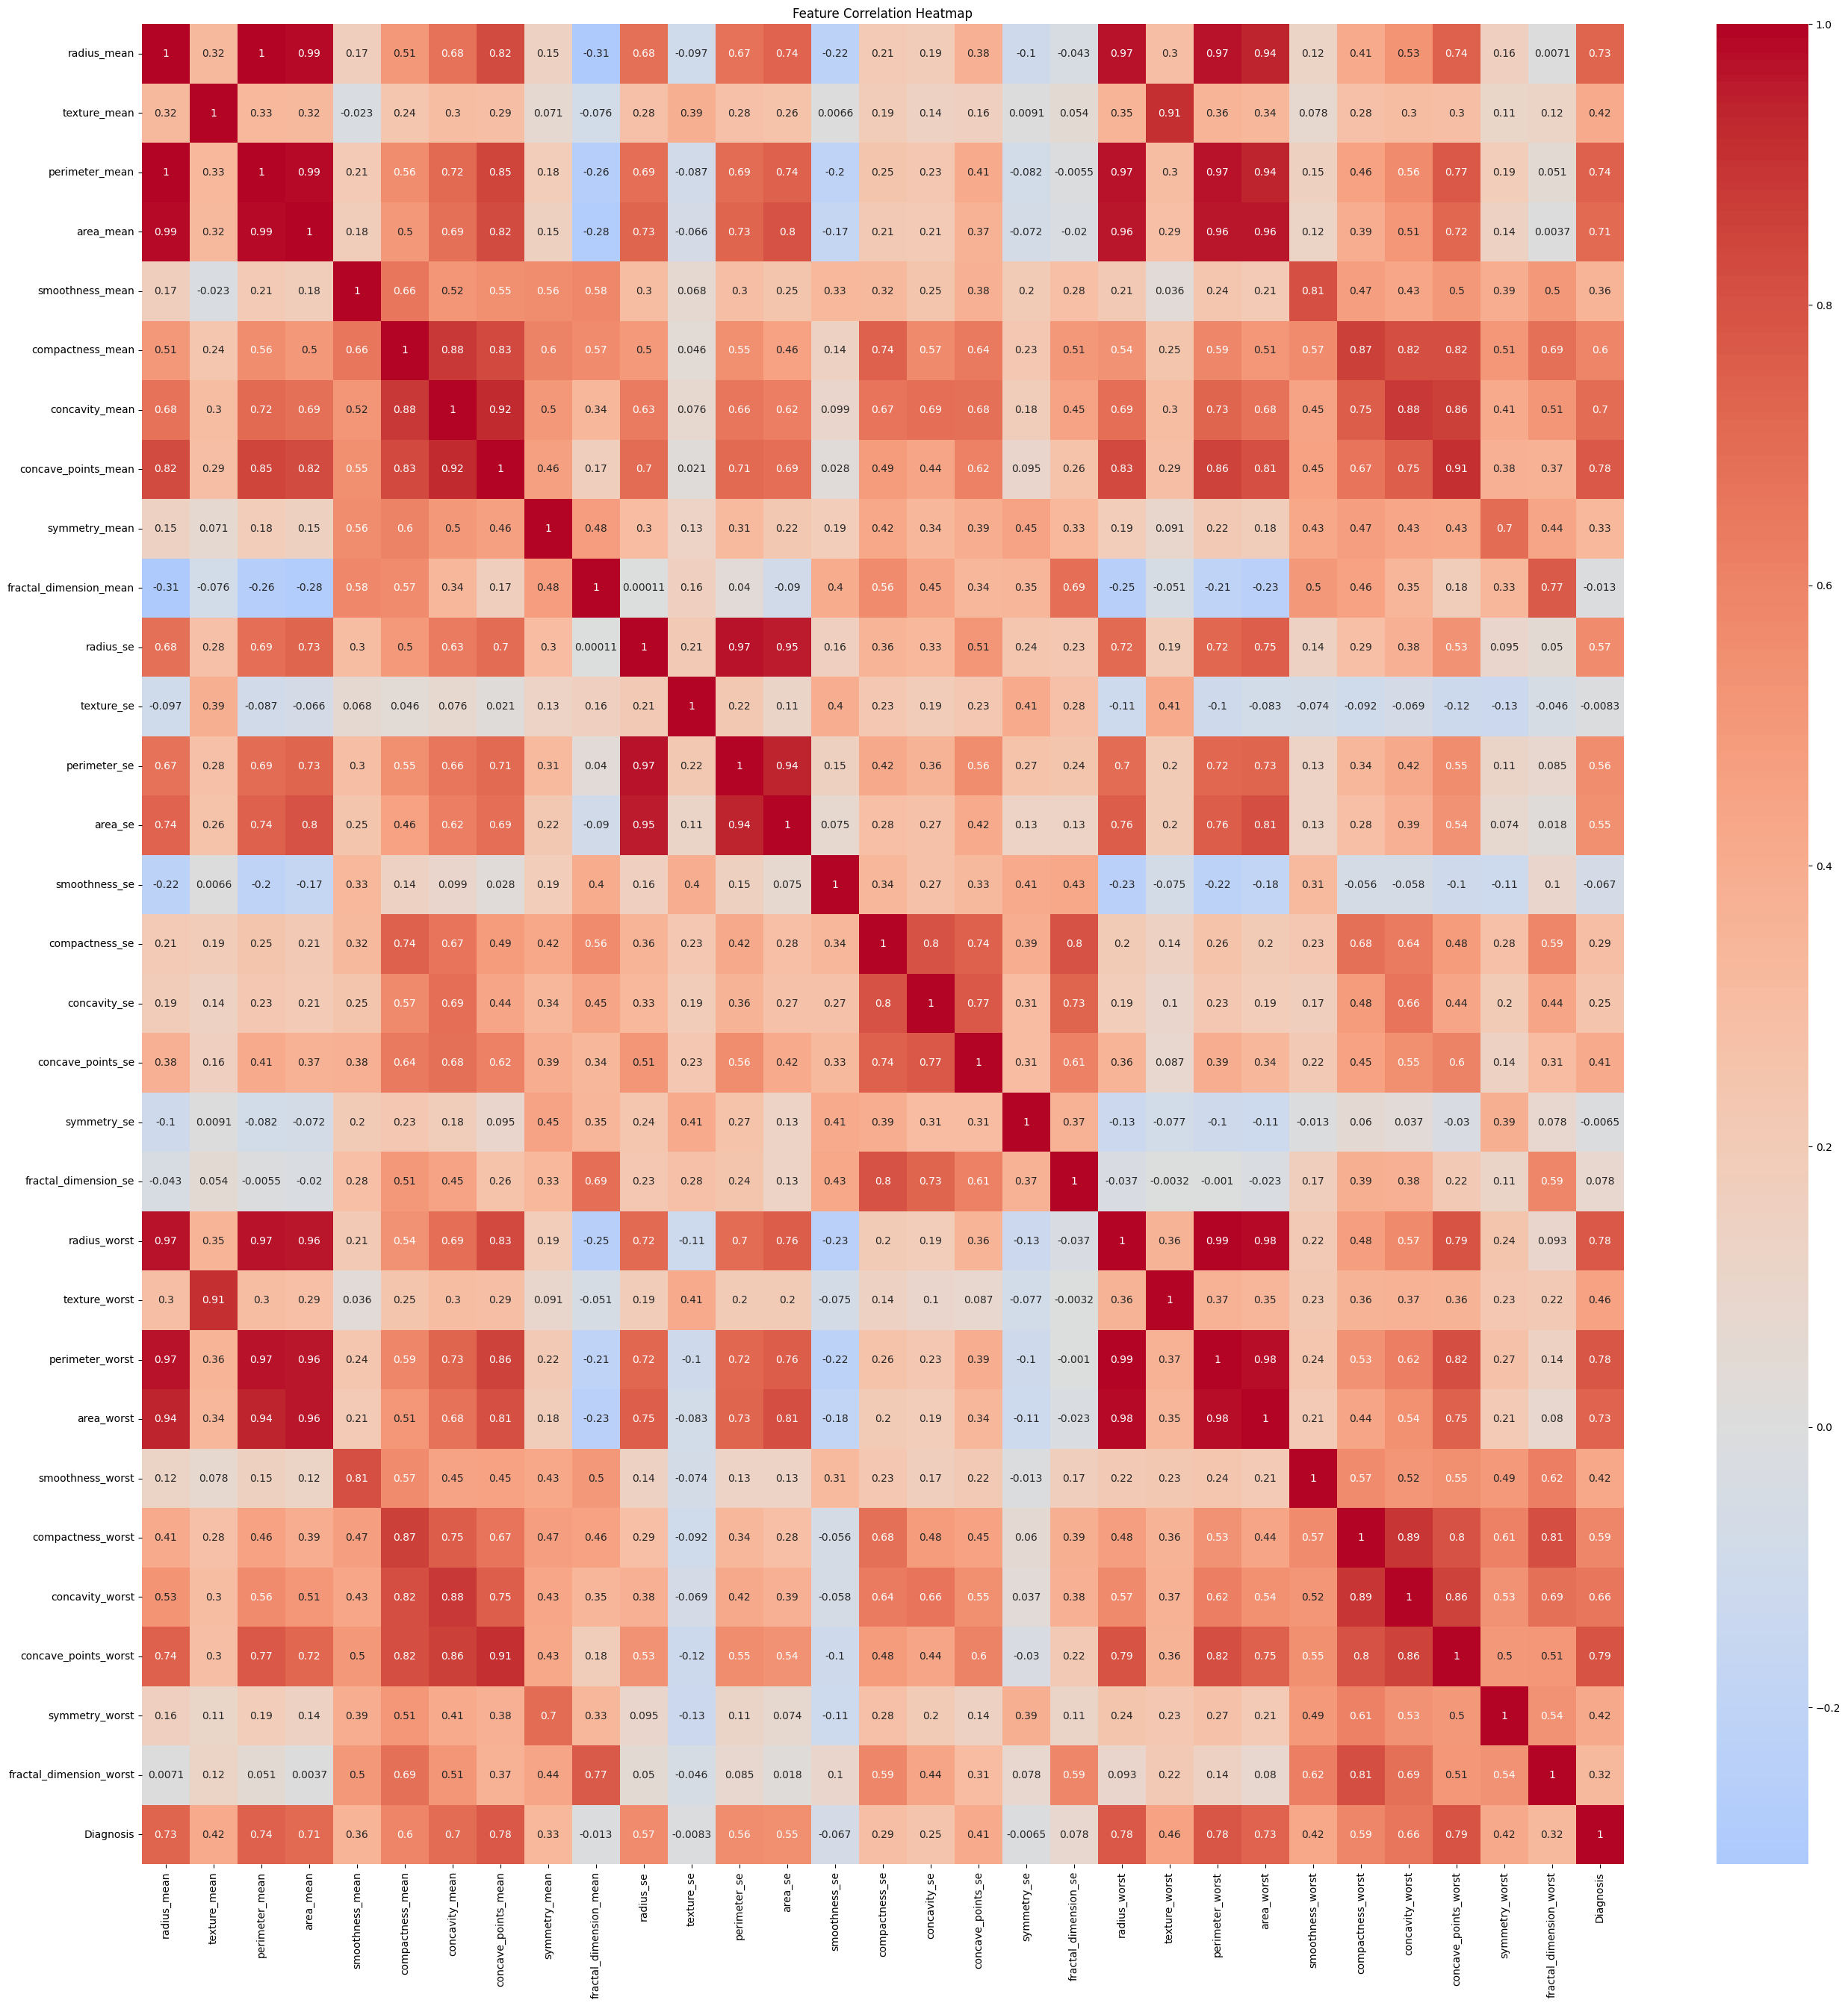

In [7]:
#  Feature correlation heatmap

plt.figure(figsize=(32,32))
corr = df_scaled.corr()
sns.heatmap(corr, cmap='coolwarm', center=0,annot=True)
plt.title('Feature Correlation Heatmap')
plt.show()

=== Decision Tree Hyperparameter Tuning Table ===
   Criterion Max Depth  Min Samples Split  Min Samples Leaf  CV Accuracy
85   entropy        10                  5                 2     0.947253
49   entropy      None                  5                 2     0.947253
76   entropy         7                  5                 2     0.947253
46   entropy      None                  5                 1     0.945055
73   entropy         7                  5                 1     0.945055
82   entropy        10                  5                 1     0.945055
27      gini         7                  2                 1     0.942857
37      gini        10                  5                 1     0.938462
1       gini      None                  5                 1     0.938462
86   entropy        10                 10                 2     0.938462

Best Decision Tree Params: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5}
Best CV Accuracy: 0.94725274

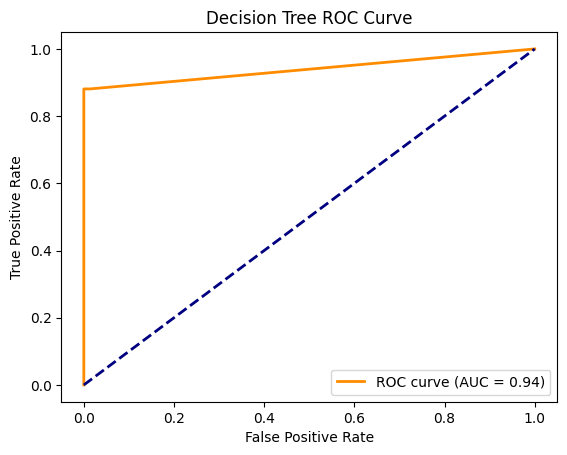

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Split data
X = df_scaled.drop('Diagnosis', axis=1)
y = df_scaled['Diagnosis']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Hyperparameter grid
dt_params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Grid search with CV
dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    dt_params,
    cv=5,
    scoring='accuracy',
    return_train_score=False,
    n_jobs=-1
)

dt_grid.fit(X_train, y_train)

# Collect all results into a DataFrame for Table 1
dt_results = pd.DataFrame(dt_grid.cv_results_)

# Select and rename relevant columns
dt_table = dt_results[[
    "param_criterion",
    "param_max_depth",
    "param_min_samples_split",
    "param_min_samples_leaf",
    "mean_test_score"
]].rename(columns={
    "param_criterion": "Criterion",
    "param_max_depth": "Max Depth",
    "param_min_samples_split": "Min Samples Split",
    "param_min_samples_leaf": "Min Samples Leaf",
    "mean_test_score": "CV Accuracy"
})

print("=== Decision Tree Hyperparameter Tuning Table ===")
print(dt_table.sort_values(by="CV Accuracy", ascending=False).head(10))  # top 10 combos

# Best estimator evaluation
best_dt = dt_grid.best_estimator_
y_pred_dt = best_dt.predict(X_test)

print("\nBest Decision Tree Params:", dt_grid.best_params_)
print("Best CV Accuracy:", dt_grid.best_score_)
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

# ROC Curve
y_proba_dt = best_dt.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_dt)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Decision Tree ROC Curve')
plt.legend(loc="lower right")
plt.show()


=== AdaBoost Hyperparameter Tuning Table ===
    n_estimators  Learning Rate  \
35           200           0.50   
32            50           0.50   
34           150           0.50   
33           100           0.50   
27           200           0.05   
31           200           0.10   
30           150           0.10   
19           200           1.00   
36            50           1.00   
39           200           1.00   

                                       Base Estimator  CV Accuracy  
35  DecisionTreeClassifier(max_depth=2, random_sta...     0.973626  
32  DecisionTreeClassifier(max_depth=2, random_sta...     0.973626  
34  DecisionTreeClassifier(max_depth=2, random_sta...     0.971429  
33  DecisionTreeClassifier(max_depth=2, random_sta...     0.969231  
27  DecisionTreeClassifier(max_depth=2, random_sta...     0.964835  
31  DecisionTreeClassifier(max_depth=2, random_sta...     0.964835  
30  DecisionTreeClassifier(max_depth=2, random_sta...     0.964835  
19  DecisionTreeC

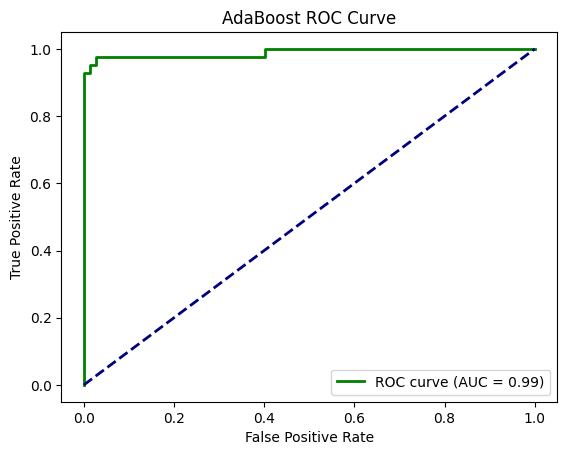

In [11]:
# AdaBoost Training with Hyperparameter Tuning

from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import pandas as pd

# 1. Base estimator (Decision Tree with shallow depth for boosting)
base_estimator = DecisionTreeClassifier(random_state=42)

# 2. Hyperparameter grid
ada_params = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'estimator': [
        DecisionTreeClassifier(max_depth=1, random_state=42),
        DecisionTreeClassifier(max_depth=2, random_state=42)
    ]
}

# 3. GridSearchCV with 5-Fold Cross-Validation
ada_grid = GridSearchCV(
    AdaBoostClassifier(random_state=42),
    ada_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=False
)

ada_grid.fit(X_train, y_train)

# 4. Collect all results into a DataFrame for Table 2
ada_results = pd.DataFrame(ada_grid.cv_results_)

# Extract and rename relevant columns
ada_table = ada_results[[
    "param_n_estimators",
    "param_learning_rate",
    "param_estimator",
    "mean_test_score"
]].rename(columns={
    "param_n_estimators": "n_estimators",
    "param_learning_rate": "Learning Rate",
    "param_estimator": "Base Estimator",
    "mean_test_score": "CV Accuracy"
})

print("=== AdaBoost Hyperparameter Tuning Table ===")
print(ada_table.sort_values(by="CV Accuracy", ascending=False).head(10))  # top 10 combos

# 5. Best estimator evaluation
best_ada = ada_grid.best_estimator_
y_pred_ada = best_ada.predict(X_test)

print("\nBest AdaBoost Params:", ada_grid.best_params_)
print("Best AdaBoost CV Accuracy:", ada_grid.best_score_)
print("\nClassification Report (AdaBoost):\n", classification_report(y_test, y_pred_ada))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ada))

# 6. ROC Curve
y_proba_ada = best_ada.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_ada)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='green', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AdaBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()


=== Gradient Boosting Hyperparameter Tuning Table ===
    n_estimators  Learning Rate  Max Depth  Subsample  CV Accuracy
92           150            0.5          5        0.8     0.969231
94           200            0.5          5        0.8     0.969231
90           100            0.5          5        0.8     0.969231
82           100            0.5          4        0.8     0.967033
62           200            0.1          4        0.8     0.967033
86           200            0.5          4        0.8     0.967033
84           150            0.5          4        0.8     0.967033
70           200            0.1          5        0.8     0.967033
88            50            0.5          5        0.8     0.967033
60           150            0.1          4        0.8     0.964835

Best Gradient Boosting Params: {'learning_rate': 0.5, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Best Gradient Boosting CV Accuracy: 0.9692307692307693

Classification Report (Gradient Boosting):


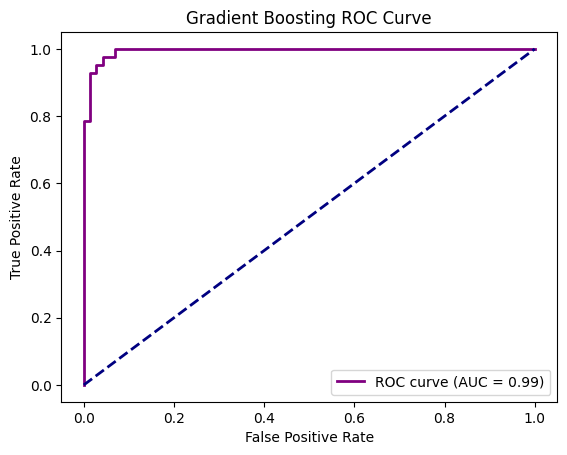

In [12]:
# Gradient Boosting with Hyperparameter Tuning

from sklearn.ensemble import GradientBoostingClassifier
import pandas as pd

# Hyperparameter grid
gb_params = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.5],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
}

# GridSearchCV
gb_grid = GridSearchCV(
    GradientBoostingClassifier(random_state=42),
    gb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=False
)

gb_grid.fit(X_train, y_train)

# Collect results into DataFrame for Table 3
gb_results = pd.DataFrame(gb_grid.cv_results_)

# Extract and rename relevant columns
gb_table = gb_results[[
    "param_n_estimators",
    "param_learning_rate",
    "param_max_depth",
    "param_subsample",
    "mean_test_score"
]].rename(columns={
    "param_n_estimators": "n_estimators",
    "param_learning_rate": "Learning Rate",
    "param_max_depth": "Max Depth",
    "param_subsample": "Subsample",
    "mean_test_score": "CV Accuracy"
})

print("=== Gradient Boosting Hyperparameter Tuning Table ===")
print(gb_table.sort_values(by="CV Accuracy", ascending=False).head(10))  # show top 10 combos

# Best estimator evaluation
best_gb = gb_grid.best_estimator_
y_pred_gb = best_gb.predict(X_test)

print("\nBest Gradient Boosting Params:", gb_grid.best_params_)
print("Best Gradient Boosting CV Accuracy:", gb_grid.best_score_)
print("\nClassification Report (Gradient Boosting):\n", classification_report(y_test, y_pred_gb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))

# ROC Curve
y_proba_gb = best_gb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_gb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='purple', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Gradient Boosting ROC Curve')
plt.legend(loc="lower right")
plt.show()


=== XGBoost Hyperparameter Tuning Table ===
     n_estimators  Learning Rate  Max Depth  Gamma  Subsample  \
572           150            0.3          5    0.1        0.8   
90            100            0.3          5    0.0        0.8   
92            150            0.3          5    0.0        0.8   
570           100            0.3          5    0.1        0.8   
574           200            0.3          5    0.1        0.8   
94            200            0.3          5    0.0        0.8   
478           200            0.3          5    0.0        0.8   
474           100            0.3          5    0.0        0.8   
476           150            0.3          5    0.0        0.8   
564           150            0.3          4    0.1        0.8   

     Colsample by Tree  CV Accuracy  
572                1.0     0.975824  
90                 0.8     0.973626  
92                 0.8     0.973626  
570                1.0     0.973626  
574                1.0     0.973626  
94          

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [08:52:10] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


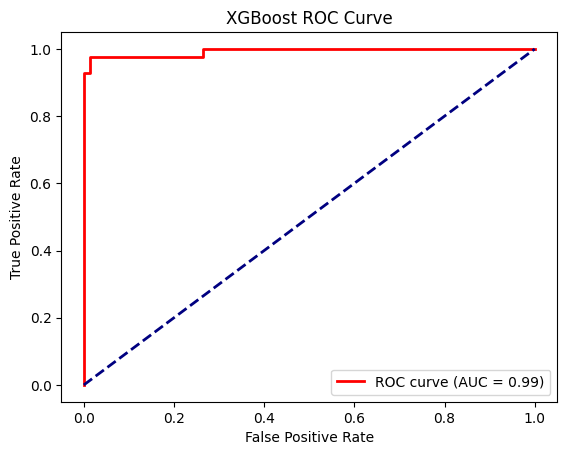

In [13]:
# XGBoost with Hyperparameter Tuning

from xgboost import XGBClassifier
import pandas as pd

# Hyperparameter grid
xgb_params = {
    'n_estimators': [50, 100, 150, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.3],
    'max_depth': [3, 4, 5],
    'gamma': [0, 0.1, 0.3, 0.5],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# GridSearchCV
xgb_grid = GridSearchCV(
    XGBClassifier(
        objective='binary:logistic',
        eval_metric='logloss',
        use_label_encoder=False,
        random_state=42
    ),
    xgb_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=False
)

xgb_grid.fit(X_train, y_train)

# Collect results into DataFrame for Table 4
xgb_results = pd.DataFrame(xgb_grid.cv_results_)

# Extract and rename relevant columns
xgb_table = xgb_results[[
    "param_n_estimators",
    "param_learning_rate",
    "param_max_depth",
    "param_gamma",
    "param_subsample",
    "param_colsample_bytree",
    "mean_test_score"
]].rename(columns={
    "param_n_estimators": "n_estimators",
    "param_learning_rate": "Learning Rate",
    "param_max_depth": "Max Depth",
    "param_gamma": "Gamma",
    "param_subsample": "Subsample",
    "param_colsample_bytree": "Colsample by Tree",
    "mean_test_score": "CV Accuracy"
})

print("=== XGBoost Hyperparameter Tuning Table ===")
print(xgb_table.sort_values(by="CV Accuracy", ascending=False).head(10))  # show top 10 combos

# Best estimator evaluation
best_xgb = xgb_grid.best_estimator_
y_pred_xgb = best_xgb.predict(X_test)

print("\nBest XGBoost Params:", xgb_grid.best_params_)
print("Best XGBoost CV Accuracy:", xgb_grid.best_score_)
print("\nClassification Report (XGBoost):\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# ROC Curve
y_proba_xgb = best_xgb.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_xgb)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='red', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC Curve')
plt.legend(loc="lower right")
plt.show()


=== Random Forest Hyperparameter Tuning Table ===
     n_estimators Max Depth Criterion Max Features  Min Samples Split  \
108            50        15      gini         sqrt                  2   
72             50        10      gini         sqrt                  2   
0              50      None      gini         sqrt                  2   
348            50         5  log_loss         None                  2   
204            50         5   entropy         None                  2   
24             50      None      gini         None                  2   
396            50        15  log_loss         sqrt                  2   
400            50        15  log_loss         sqrt                  5   
52             50         5      gini         log2                  5   
363           200        10  log_loss         sqrt                  2   

     CV Accuracy  
108     0.967033  
72      0.967033  
0       0.967033  
348     0.964835  
204     0.964835  
24      0.962637  
396     0.962

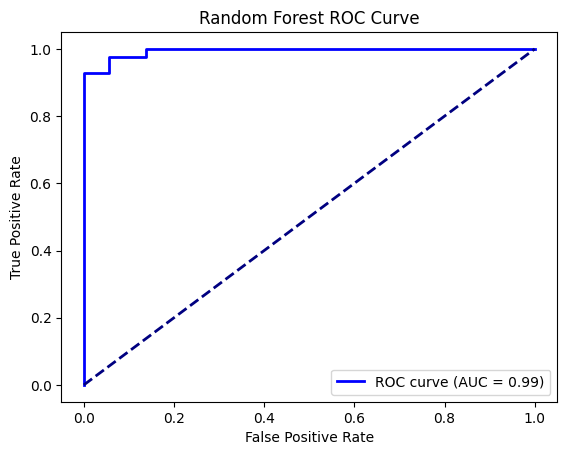

In [14]:
# Random Forest with Hyperparameter Tuning

from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# Hyperparameter grid
rf_params = {
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [None, 5, 10, 15],
    'criterion': ['gini', 'entropy', 'log_loss'],
    'max_features': ['sqrt', 'log2', None],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV
rf_grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    return_train_score=False
)

rf_grid.fit(X_train, y_train)

# Collect results into DataFrame for Table 5
rf_results = pd.DataFrame(rf_grid.cv_results_)

# Extract and rename relevant columns
rf_table = rf_results[[
    "param_n_estimators",
    "param_max_depth",
    "param_criterion",
    "param_max_features",
    "param_min_samples_split",
    "mean_test_score"
]].rename(columns={
    "param_n_estimators": "n_estimators",
    "param_max_depth": "Max Depth",
    "param_criterion": "Criterion",
    "param_max_features": "Max Features",
    "param_min_samples_split": "Min Samples Split",
    "mean_test_score": "CV Accuracy"
})

print("=== Random Forest Hyperparameter Tuning Table ===")
print(rf_table.sort_values(by="CV Accuracy", ascending=False).head(10))  # show top 10 combos

# Best estimator evaluation
best_rf = rf_grid.best_estimator_
y_pred_rf = best_rf.predict(X_test)

print("\nBest Random Forest Params:", rf_grid.best_params_)
print("Best Random Forest CV Accuracy:", rf_grid.best_score_)
print("\nClassification Report (Random Forest):\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

# ROC Curve
y_proba_rf = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [19]:
from sklearn.ensemble import StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score

# Helper function to train & evaluate stacking models
def evaluate_stacking(base_estimators, final_estimator):
    stack_model = StackingClassifier(
        estimators=base_estimators,
        final_estimator=final_estimator,
        passthrough=False,
        n_jobs=-1
    )
    stack_model.fit(X_train, y_train)
    y_pred = stack_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, f1

# Define base model sets and final estimators
stack_configs = [
    # 1. SVM, Naïve Bayes, Decision Tree → Logistic Regression
    (
        [
            ('svm', SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42)),
            ('nb', GaussianNB()),
            ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
        ],
        LogisticRegression(max_iter=1000, random_state=42)
    ),
    # 2. SVM, Naïve Bayes, Decision Tree → Random Forest
    (
        [
            ('svm', SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42)),
            ('nb', GaussianNB()),
            ('dt', DecisionTreeClassifier(max_depth=5, random_state=42))
        ],
        RandomForestClassifier(n_estimators=100, random_state=42)
    ),
    # 3. SVM, Decision Tree, KNN → Logistic Regression
    (
        [
            ('svm', SVC(probability=True, kernel='rbf', C=1, gamma='scale', random_state=42)),
            ('dt', DecisionTreeClassifier(max_depth=5, random_state=42)),
            ('knn', KNeighborsClassifier(n_neighbors=5))
        ],
        LogisticRegression(max_iter=1000, random_state=42)
    )
]


# Run all stacking configurations and print results
results = []
best_acc = 0
best_stack = None  # define before using

for i, (base_models, final_est) in enumerate(stack_configs, start=1):
    stack_model = StackingClassifier(
        estimators=base_models,
        final_estimator=final_est,
        passthrough=False,
        n_jobs=-1
    )
    stack_model.fit(X_train, y_train)
    y_pred = stack_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    results.append((i, base_models, type(final_est).__name__, acc, f1))
    print(f"Stacking {i}: Final Estimator = {type(final_est).__name__}")
    print(f"Accuracy: {acc:.4f} | F1 Score: {f1:.4f}\n")

    # Track best stack model
    if acc > best_acc:
        best_acc = acc
        best_stack = stack_model

# Convert results to DataFrame for Table 6
stack_df = pd.DataFrame(
    [(f"{', '.join([name.upper() for name, _ in bm])}", fe, acc, f1)
     for _, bm, fe, acc, f1 in results],
    columns=["Base Models", "Final Estimator", "Accuracy", "F1 Score"]
)

print("=== Stacked Ensemble Results ===")
print(stack_df)
print("\nBest Stacked Model chosen for CV:", best_stack)


Stacking 1: Final Estimator = LogisticRegression
Accuracy: 0.9649 | F1 Score: 0.9500

Stacking 2: Final Estimator = RandomForestClassifier
Accuracy: 0.9649 | F1 Score: 0.9512

Stacking 3: Final Estimator = LogisticRegression
Accuracy: 0.9649 | F1 Score: 0.9512

=== Stacked Ensemble Results ===
    Base Models         Final Estimator  Accuracy  F1 Score
0   SVM, NB, DT      LogisticRegression  0.964912   0.95000
1   SVM, NB, DT  RandomForestClassifier  0.964912   0.95122
2  SVM, DT, KNN      LogisticRegression  0.964912   0.95122

Best Stacked Model chosen for CV: StackingClassifier(estimators=[('svm',
                                SVC(C=1, probability=True, random_state=42)),
                               ('nb', GaussianNB()),
                               ('dt',
                                DecisionTreeClassifier(max_depth=5,
                                                       random_state=42))],
                   final_estimator=LogisticRegression(max_iter=1000,
          

In [20]:
# 5-Fold Cross-Validation Results Compilation

from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings("ignore")

models = {
    "Decision Tree": best_dt,
    "AdaBoost": best_ada,
    "Gradient Boosting": best_gb,
    "XGBoost": best_xgb,
    "Random Forest": best_rf,
    "Stacked Model": best_stack
}

cv_results = {}

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    cv_results[name] = scores
    print(f"{name} Fold Accuracies: {scores}")
    print(f"{name} Average Accuracy: {scores.mean():.4f}\n")

# Create DataFrame for Table 7
cv_df = pd.DataFrame(cv_results)
cv_df.index = [f"Fold {i+1}" for i in range(5)]
cv_df.loc["Average Accuracy"] = cv_df.mean()
cv_df


Decision Tree Fold Accuracies: [0.88596491 0.92982456 0.93859649 0.93859649 0.94690265]
Decision Tree Average Accuracy: 0.9280

AdaBoost Fold Accuracies: [0.96491228 0.95614035 0.99122807 0.98245614 0.96460177]
AdaBoost Average Accuracy: 0.9719

Gradient Boosting Fold Accuracies: [0.94736842 0.92982456 0.98245614 0.98245614 0.98230088]
Gradient Boosting Average Accuracy: 0.9649

XGBoost Fold Accuracies: [0.98245614 0.96491228 0.99122807 0.97368421 0.98230088]
XGBoost Average Accuracy: 0.9789

Random Forest Fold Accuracies: [0.92105263 0.92982456 0.98245614 0.97368421 0.96460177]
Random Forest Average Accuracy: 0.9543

Stacked Model Fold Accuracies: [0.95614035 0.95614035 0.98245614 0.97368421 0.94690265]
Stacked Model Average Accuracy: 0.9631



,Decision Tree,AdaBoost,Gradient Boosting,XGBoost,Random Forest,Stacked Model
Fold 1,0.885965,0.964912,0.947368,0.982456,0.921053,0.956140
Fold 2,0.929825,0.956140,0.929825,0.964912,0.929825,0.956140
Fold 3,0.938596,0.991228,0.982456,0.991228,0.982456,0.982456
Fold 4,0.938596,0.982456,0.982456,0.973684,0.973684,0.973684
Fold 5,0.946903,0.964602,0.982301,0.982301,0.964602,0.946903
Average Accuracy,0.927977,0.971868,0.964881,0.978916,0.954324,0.963065
